In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from taigapy import TaigaClient
tc = TaigaClient()

In [4]:
AvanaGuideMap = tc.get(name='chronos2-0test3-internal-d93b', version=1, file='AvanaGuideMap')

In [5]:
AvanaGuideMap.head()

,sgRNA,GenomeAlignment,Gene,nAlignments,DropReason,UsedByChronos
0,AAAAAAATCCAGCAATGCAG,chr10_110964620_+,SHOC2 (8036),1.0,None,True
1,AAAAAACCCGTAGATAGCCT,chr12_95003615_+,NDUFA12 (55967),1.0,None,True
2,AAAAAAGAAGAAAAAACCAG,chr4_75970356_-,SDAD1 (55153),1.0,None,True
3,AAAAAAGCTCAAGAAGGAGG,chr2_33588446_-,FAM98A (25940),1.0,None,True
4,AAAAAAGGCTGTAAAAGCGT,chr19_19891600_+,ZNF253 (56242),1.0,None,True


(array([95028.,  6975.,     0.,     0.,  9017.,     0., 14367.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 45042.]),
 array([    0. ,  2252.1,  4504.2,  6756.3,  9008.4, 11260.5, 13512.6,
        15764.7, 18016.8, 20268.9, 22521. , 24773.1, 27025.2, 29277.3,
        31529.4, 33781.5, 36033.6, 38285.7, 40537.8, 42789.9, 45042. ]),
 <BarContainer object of 20 artists>)

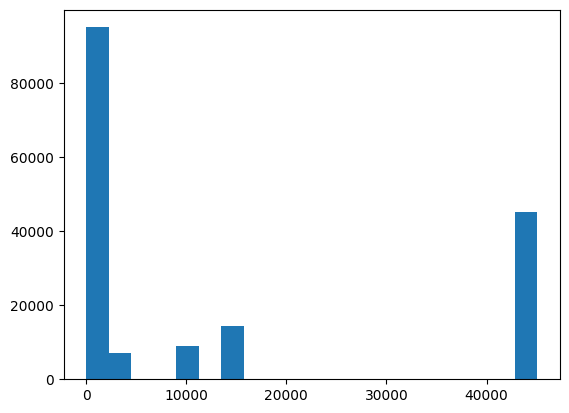

In [6]:
plt.hist(AvanaGuideMap.nAlignments, bins=20)

In [7]:
# AvanaLogfoldChange = tc.get(name='chronos2-0test3-internal-d93b', version=1, file='AvanaLogfoldChange')

In [8]:
# AvanaLogfoldChange.head()

In [9]:
# AvanaLogfoldChange.shape, AvanaGuideMap.shape

In [10]:
# np.intersect1d(AvanaGuideMap.loc[AvanaGuideMap.nAlignments==1, :].sgRNA, AvanaLogfoldChange.index).shape

In [11]:
# AvanaGuideMap.head()

In [12]:
# AvanaLogfoldChange.head()

In [13]:
ScreenNaiveGeneScore = tc.get(name='chronos2-0test3-internal-d93b', version=1, file='ScreenNaiveGeneScore')

In [14]:
ScreenNaiveGeneScore.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,GYPB (2994),KRTAP9-3 (83900),LCE2C (353140),LIMS1 (3987),PAGE2B (389860),PKD1L2 (114780),RPL15 (6138),RPSA (3921),SIGLEC14 (100049587),SUMO2 (6613)
SC-000004.AV01,0.152865,-0.043086,-0.416068,-0.075270,0.240090,-0.347434,0.085568,-0.483119,0.417768,0.154297,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SC-000005.AV01,-0.119600,0.128265,0.049011,0.092756,-0.071081,-0.009292,0.200558,-0.257414,0.024973,0.134880,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SC-000007.AV01,0.039226,-0.063372,0.005090,0.065321,0.053580,0.228591,-0.037157,-0.574127,-0.083571,0.530762,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SC-000009.AV01,0.379326,-0.329258,-0.018031,-0.040333,0.311013,0.047712,0.058077,-0.851510,0.204683,0.023418,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SC-000011.AV01,0.481769,-0.029556,0.134585,0.687208,0.250384,-0.750413,0.253780,-0.338910,0.269076,0.067377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
AvanaGuideMap.loc[AvanaGuideMap.nAlignments==1, 'Gene'].unique().shape

(17840,)

In [16]:
OmicsCNSegmentsProfile = tc.get(name='internal-23q2-1e49', version=59, file='OmicsCNSegmentsProfile')


In [17]:
OmicsCNSegmentsProfile.head()

,ProfileID,Chromosome,Start,End,SegmentMean,NumProbes,Status
0,PR-00UtU3,1,10001,7514727,0.848801,6365,0
1,PR-00UtU3,1,7514728,28452744,0.814937,19189,0
2,PR-00UtU3,1,28452745,41756578,0.827998,12815,0
3,PR-00UtU3,1,41756579,42098578,0.884138,342,0
4,PR-00UtU3,1,42098579,45896082,0.832715,3742,0


In [18]:
OmicsCNGene = tc.get(name='internal-23q2-1e49', version=59, file='OmicsCNGene')

In [19]:
OmicsExpressionProteinCodingGenesTPMLogp1 = tc.get(name='internal-23q2-1e49', version=59, file='OmicsExpressionProteinCodingGenesTPMLogp1')

In [20]:
OmicsExpressionProteinCodingGenesTPMLogp1.head()

,TSPAN6 (7105),TNMD (64102),DPM1 (8813),SCYL3 (57147),C1orf112 (55732),FGR (2268),CFH (3075),FUCA2 (2519),GCLC (2729),NFYA (4800),...,H3C2 (8358),H3C3 (8352),AC098582.1 (8916),DUS4L-BCAP29 (115253422),C8orf44-SGK3 (100533105),ELOA3B (728929),NPBWR1 (2831),ELOA3D (100506888),ELOA3 (162699),CDR1 (1038)
ACH-001113,4.331992,0.000000,7.364660,2.792855,4.471187,0.028569,1.226509,3.044394,6.500005,4.739848,...,2.689299,0.189034,0.201634,2.130931,0.555816,0.0,0.275007,0.0,0.0,0.000000
ACH-001289,4.567424,0.584963,7.106641,2.543496,3.504620,0.000000,0.189034,3.813525,4.221877,3.481557,...,1.286881,1.049631,0.321928,1.464668,0.632268,0.0,0.014355,0.0,0.0,0.000000
ACH-001339,3.150560,0.000000,7.379118,2.333424,4.228049,0.056584,1.310340,6.687201,3.682573,3.273516,...,0.594549,1.097611,0.831877,2.946731,0.475085,0.0,0.084064,0.0,0.0,0.042644
ACH-001538,5.085340,0.000000,7.154211,2.545968,3.084064,0.000000,5.868390,6.165309,4.489928,3.956986,...,0.214125,0.632268,0.298658,1.641546,0.443607,0.0,0.028569,0.0,0.0,0.000000
ACH-000242,6.729417,0.000000,6.537917,2.456806,3.867896,0.799087,7.208478,5.570159,7.127117,4.568032,...,1.117695,2.358959,0.084064,1.910733,0.000000,0.0,0.464668,0.0,0.0,0.000000


In [21]:
overlap_exp_cn = np.intersect1d(OmicsCNGene.index.values, OmicsExpressionProteinCodingGenesTPMLogp1.index.values)
overlap_genes = np.intersect1d(OmicsCNGene.columns.values, OmicsExpressionProteinCodingGenesTPMLogp1.columns.values)
expression = OmicsExpressionProteinCodingGenesTPMLogp1.loc[overlap_exp_cn, overlap_genes]

In [22]:
cnv = OmicsCNGene.loc[overlap_exp_cn, overlap_genes]

In [23]:
cnv.shape, expression.shape

((1687, 19180), (1687, 19180))

In [24]:
import pandas as pd
from scipy.stats import pearsonr
pearson_exp_cnv = []
for sample in cnv.index:
    exp_cnv = pd.DataFrame({"CNV": cnv.loc[sample], "EXP": expression.loc[sample]})
    #print(exp_cnv.shape)
    pearson_exp_cnv.append(exp_cnv.dropna().corr().values[1][0])

(array([ 13.,  10.,  35.,  57., 249., 422., 497., 300.,  82.,  22.]),
 array([-0.04163646, -0.01935675,  0.00292296,  0.02520267,  0.04748239,
         0.0697621 ,  0.09204181,  0.11432152,  0.13660123,  0.15888095,
         0.18116066]),
 <BarContainer object of 10 artists>)

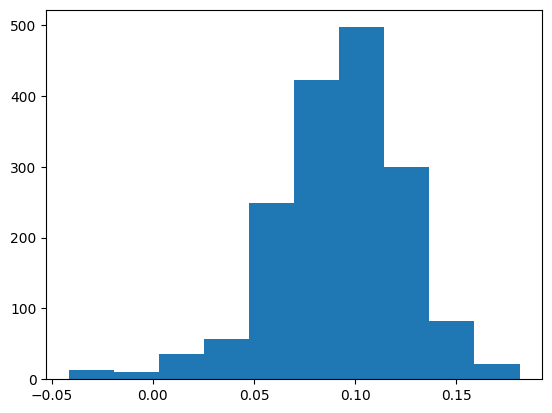

In [25]:
plt.hist(pearson_exp_cnv)

In [26]:
OmicsCNGene.loc['ACH-000917', :]

DDX11L1 (84771)          0.931048
WASH7P (653635)          0.931048
MIR6859-1 (102466751)    0.931048
MIR1302-2 (100302278)    0.931048
FAM138A (645520)         0.931048
                           ...   
SNORD38B (94163)              NaN
SCARNA4 (677771)              NaN
SNORA50A (677830)             NaN
SNORD3D (780854)              NaN
POLR2J3 (548644)              NaN
Name: ACH-000917, Length: 25368, dtype: float64

In [71]:
OmicsProfiles = tc.get(name='public-23q2-19de', file='OmicsProfiles')

No dataset version provided. Using version 84.


[##################]100% |  24.2 MiB/s |  57.5 KiB /  57.5 KiB | ETA:  00:00:00


In [72]:
OmicsProfiles.head()

,ProfileID,ModelConditionID,ModelID,Datatype,WESKit
0,PR-00UtU3,MC-001131-kkJv,ACH-001131,wgs,NaN
1,PR-01r7OM,MC-000957-Yckn,ACH-000957,rna,NaN
2,PR-02XmLG,MC-002785-qo9e,ACH-002785,rna,NaN
3,PR-04VvBz,MC-001289-BpdI,ACH-001289,wes,ICE
4,PR-09gmEI,MC-000520-YIm7,ACH-000520,rna,NaN


In [29]:
OmicsProfiles.ModelID.unique().shape, OmicsProfiles.ModelID.shape

((1821,), (3858,))

In [30]:
OmicsProfiles.loc[OmicsProfiles.ModelID== 'ACH-001131', :]

,ProfileID,ModelConditionID,ModelID,Datatype,WESKit
0,PR-00UtU3,MC-001131-kkJv,ACH-001131,wgs,None


In [31]:
OmicsProfiles.loc[OmicsProfiles.ModelID== 'ACH-000277', :]

,ProfileID,ModelConditionID,ModelID,Datatype,WESKit
994,PR-cydJsN,MC-000277-jVkn,ACH-000277,wes,AGILENT
3098,PR-uLwAEv,MC-000277-Alx7,ACH-000277,wgs,None
3769,PR-ZvWIf3,MC-000277-Alx7,ACH-000277,rna,None


In [32]:
OmicsDefaultModelProfiles = tc.get(name='internal-23q2-1e49', version=59, file='OmicsDefaultModelProfiles')

In [33]:
OmicsDefaultModelProfiles.head()

,ModelID,ProfileID,ProfileType
0,ACH-000447,PR-Vd2mq2,rna
1,ACH-000447,PR-P7ivEQ,dna
2,ACH-000844,PR-edUTwR,rna
3,ACH-000844,PR-QzzYAo,dna
4,ACH-002438,PR-Jt5ZBG,dna


In [34]:
CRISPRInferredCommonEssentials = tc.get(name='internal-22q4-56d4', version=93, file='CRISPRInferredCommonEssentials')

In [35]:
CRISPRInferredCommonEssentials.head()

,Essentials
0,AAMP (14)
1,AARS1 (16)
2,AATF (26574)
3,ABCB7 (22)
4,ABCE1 (6059)


In [36]:
ScreenSequenceMap = tc.get(name='internal-22q4-56d4', version=93, file='ScreenSequenceMap')

In [37]:
ScreenSequenceMap.loc[ScreenSequenceMap.ModelID.isin(['ACH-001799', 'ACH-001819']), :]

,SequenceID,ScreenID,Days,pDNABatch,Replicate,ScreenType,ModelID,ModelConditionID,Library,PassesQC
1880,LPS141-311cas9-RepA-p5_Avana-3,SC-001799.AV01,21,Avana-3,A,2DS,ACH-001799,MC-001799-AkA5,Avana,True
1886,MFM223-311cas9-RepA-p6_Avana-4,SC-001819.AV01,21,Avana-4,A,2DS,ACH-001819,MC-001819-imt5,Avana,True
1887,MFM223-311cas9-RepB-p6_Avana-4,SC-001819.AV01,21,Avana-4,B,2DS,ACH-001819,MC-001819-imt5,Avana,True
2804,MFM223_c903R1_KY-2,SC-001819.KY01,14,KY-2,A,2DS,ACH-001819,MC-001819-XxSH,KY,True
2805,MFM223_c903R2_KY-2,SC-001819.KY01,14,KY-2,B,2DS,ACH-001819,MC-001819-XxSH,KY,True
2806,MFM223_c903R3_KY-2,SC-001819.KY01,14,KY-2,C,2DS,ACH-001819,MC-001819-XxSH,KY,True


In [38]:
CRISPRInferredCommonEssentials.shape

(1743, 1)

In [39]:
ScreenNaiveGeneScore.shape

(1376, 18443)

In [40]:
ScreenNaiveGeneScore = ScreenNaiveGeneScore.loc[:, np.setdiff1d(ScreenNaiveGeneScore.columns.values, CRISPRInferredCommonEssentials.Essentials.values)]

In [41]:
ScreenNaiveGeneScore = ScreenNaiveGeneScore.loc[:, np.intersect1d(ScreenNaiveGeneScore.columns, AvanaGuideMap.loc[AvanaGuideMap.nAlignments==1, 'Gene'].unique())]

In [42]:
ScreenNaiveGeneScore.head()

,A1BG (1),A1CF (29974),A2M (2),A2ML1 (144568),A3GALT2 (127550),A4GALT (53947),A4GNT (51146),AAAS (8086),AACS (65985),AADAC (13),...,ZW10 (9183),ZWILCH (55055),ZXDA (7789),ZXDB (158586),ZXDC (79364),ZYG11A (440590),ZYG11B (79699),ZYX (7791),ZZEF1 (23140),ZZZ3 (26009)
SC-000004.AV01,0.152865,-0.043086,-0.416068,-0.075270,0.240090,-0.347434,0.085568,-0.483119,0.417768,0.154297,...,0.057836,0.021106,0.042039,-0.008530,0.234960,0.034915,-0.421824,0.373499,0.156196,-0.259398
SC-000005.AV01,-0.119600,0.128265,0.049011,0.092756,-0.071081,-0.009292,0.200558,-0.257414,0.024973,0.134880,...,-0.247969,-0.064524,-0.108863,-0.164297,0.099105,-0.063141,-0.090448,0.097767,-0.075197,-0.148399
SC-000007.AV01,0.039226,-0.063372,0.005090,0.065321,0.053580,0.228591,-0.037157,-0.574127,-0.083571,0.530762,...,-0.568655,-0.264826,0.012658,0.232890,0.365632,-0.081558,-0.301304,-0.147613,-0.631748,-0.577133
SC-000009.AV01,0.379326,-0.329258,-0.018031,-0.040333,0.311013,0.047712,0.058077,-0.851510,0.204683,0.023418,...,-0.422606,-0.272461,-0.013478,0.062675,0.035207,0.026576,-0.700326,0.311198,-0.171799,-0.465616
SC-000011.AV01,0.481769,-0.029556,0.134585,0.687208,0.250384,-0.750413,0.253780,-0.338910,0.269076,0.067377,...,-1.085000,-1.182450,-0.162862,-0.103503,0.795103,0.523633,-0.273512,-0.069095,-0.158023,-0.034917


In [43]:
OmicsCNGene.shape

(2084, 25368)

In [44]:
OmicsCNGene.head()

,DDX11L1 (84771),WASH7P (653635),MIR6859-1 (102466751),MIR1302-2 (100302278),FAM138A (645520),OR4F5 (79501),WASH9P (102723897),MIR6859-2 (102465909),OR4F29 (729759),AL669831.3 (101928626),...,BPY2C (442868),TTTY4C (474150),CSPG4P1Y (114758),CDY1 (9085),TTTY3 (114760),SNORD38B (94163),SCARNA4 (677771),SNORA50A (677830),SNORD3D (780854),POLR2J3 (548644)
ACH-000667,2.114107,2.114107,2.114107,2.114107,2.114107,3.880916e-08,1.417715,1.417715,1.417715,1.417715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACH-001148,1.019314,1.019314,1.019314,1.019314,1.019314,1.019314e+00,1.019314,1.019314,1.019314,1.019314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACH-000159,0.977269,0.977269,0.977269,0.977269,0.977269,9.772694e-01,0.977269,0.977269,0.977269,0.977269,...,0.729053,0.729053,0.729053,0.729053,0.729053,NaN,NaN,NaN,NaN,NaN
ACH-001519,1.358684,1.358684,1.358684,1.358684,1.358684,1.358684e+00,1.358684,1.358684,0.000006,0.840994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACH-002454,0.846190,0.846190,0.846190,0.846190,0.846190,8.461899e-01,0.846190,0.846190,0.846190,0.846190,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
OmicsCNGene.loc['ACH-000277', :].shape

(25368,)

In [46]:
OmicsCNGene.loc['ACH-000277',:]

DDX11L1 (84771)          0.8665
WASH7P (653635)          0.8665
MIR6859-1 (102466751)    0.8665
MIR1302-2 (100302278)    0.8665
FAM138A (645520)         0.8665
                          ...  
SNORD38B (94163)            NaN
SCARNA4 (677771)            NaN
SNORA50A (677830)           NaN
SNORD3D (780854)            NaN
POLR2J3 (548644)            NaN
Name: ACH-000277, Length: 25368, dtype: float64

In [47]:
OmicsCNGene.index.unique().shape, OmicsCNGene.shape

((2084,), (2084, 25368))

In [48]:
ScreenSequenceMap.head()

,SequenceID,ScreenID,Days,pDNABatch,Replicate,ScreenType,ModelID,ModelConditionID,Library,PassesQC
0,Colo699-311cas9-RepA-p6_Avana-4,SC-001041.AV01,21,Avana-4,A,2DS,ACH-001041,MC-001041-CkXW,Avana,True
1,Colo699-311cas9-RepB-p6_Avana-4,SC-001041.AV01,21,Avana-4,B,2DS,ACH-001041,MC-001041-CkXW,Avana,True
2,HSB-2-311cas9_RepA_p4_Avana-3,SC-001737.AV01,21,Avana-3,A,2DS,ACH-001737,MC-001737-6D5K,Avana,True
3,HSB-2-311cas9_RepB_p4_Avana-3,SC-001737.AV01,21,Avana-3,B,2DS,ACH-001737,MC-001737-6D5K,Avana,True
4,NCIH1339-311Cas9_RepA_p6_Avana-3,SC-000921.AV01,21,Avana-3,A,2DS,ACH-000921,MC-000921-P628,Avana,True


In [49]:
import pandas as pd
import seaborn as sns

def pl_scatterplot_boxplot(ACH_id, cnv_cutoff=2):
    screen_id = ScreenSequenceMap.loc[ScreenSequenceMap.ModelID.isin([ACH_id]), :].ScreenID.unique()[0]
    print(screen_id)
    overlap_index = np.intersect1d(ScreenNaiveGeneScore.loc[screen_id, :].dropna().index, OmicsCNGene.loc[ACH_id, :].dropna().index)
    data = pd.DataFrame({'CN': OmicsCNGene.loc[ACH_id, :].dropna().loc[overlap_index], 
                         'ScreenNaiveScore': ScreenNaiveGeneScore.loc[screen_id, :].dropna().loc[overlap_index]})
    print(data.head())
    data.loc[:, 'ScreenNaiveScore'] -= data.loc[:, 'ScreenNaiveScore'].mean()
    # Filter common essential genes
    # Filter high copy number variation genes > 4
    data = data.loc[data.CN>=cnv_cutoff, :]
    data.loc[:, 'CNquantile'] = pd.cut(data.CN, 5, precision=1)
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(9.3, 5)
    sns.scatterplot(x='CN', y='ScreenNaiveScore', size=1, data=data, ax=ax[0])
    sns.boxplot(x='CNquantile', y='ScreenNaiveScore', data=data, ax=ax[1] )
    ax[1].tick_params(axis='x', rotation=90)

In [50]:
import pandas as pd
import seaborn as sns

def eval_cnv_expr_cor(ACH_id, cnv_cutoff: float =2):
    try:
        screen_id = ScreenSequenceMap.loc[ScreenSequenceMap.ModelID.isin([ACH_id]), :].ScreenID.unique()[0]
        overlap_index = np.intersect1d(ScreenNaiveGeneScore.loc[screen_id, :].dropna().index, OmicsCNGene.loc[ACH_id, :].dropna().index)
        data = pd.DataFrame({'CN': OmicsCNGene.loc[ACH_id, :].dropna().loc[overlap_index], 
                             'ScreenNaiveScore': ScreenNaiveGeneScore.loc[screen_id, :].dropna().loc[overlap_index]})
        data = data.loc[data.CN>=cnv_cutoff, :]    
        return data.corr().values[1][0]
    except:
        return np.nan

SC-001819.AV01
                        CN  ScreenNaiveScore
A1BG (1)          1.427293          0.036079
A1CF (29974)      1.885421         -0.131646
A2M (2)           1.128177         -0.051298
A2ML1 (144568)    1.128177          0.191844
A3GALT2 (127550)  0.981809          0.088041
SC-001799.AV01
                        CN  ScreenNaiveScore
A1BG (1)          0.913237          0.270143
A1CF (29974)      0.701134         -0.134410
A2M (2)           0.950462         -0.095097
A2ML1 (144568)    0.950462          0.101601
A3GALT2 (127550)  1.294580          0.179018
SC-000277.AV01
                        CN  ScreenNaiveScore
A1BG (1)          1.031555          0.046622
A1CF (29974)      0.926843          0.128247
A2M (2)           1.133560         -0.159729
A2ML1 (144568)    1.133560          0.107116
A3GALT2 (127550)  0.879213         -0.035222
ACH-002983
SC-000917.AV01
                        CN  ScreenNaiveScore
A1BG (1)          0.952562         -0.041185
A1CF (29974)      1.240078   

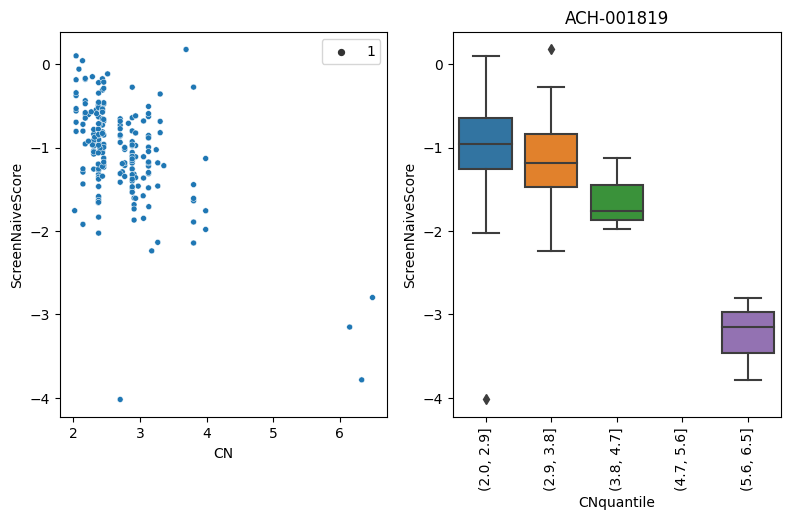

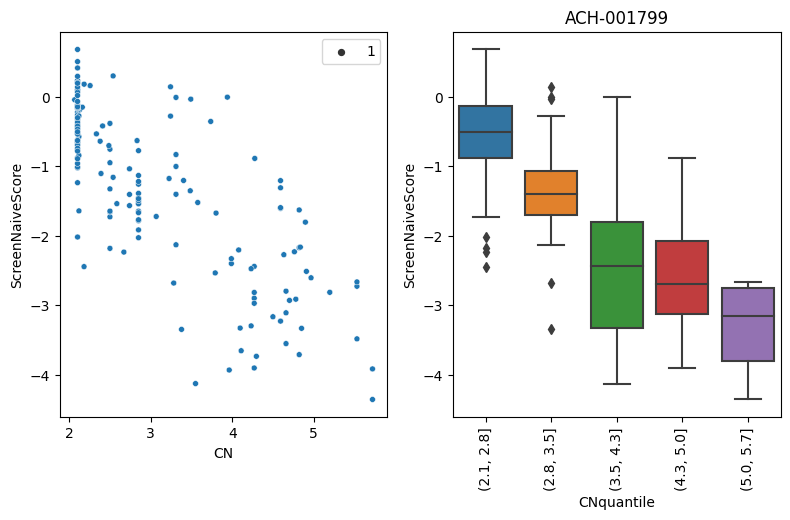

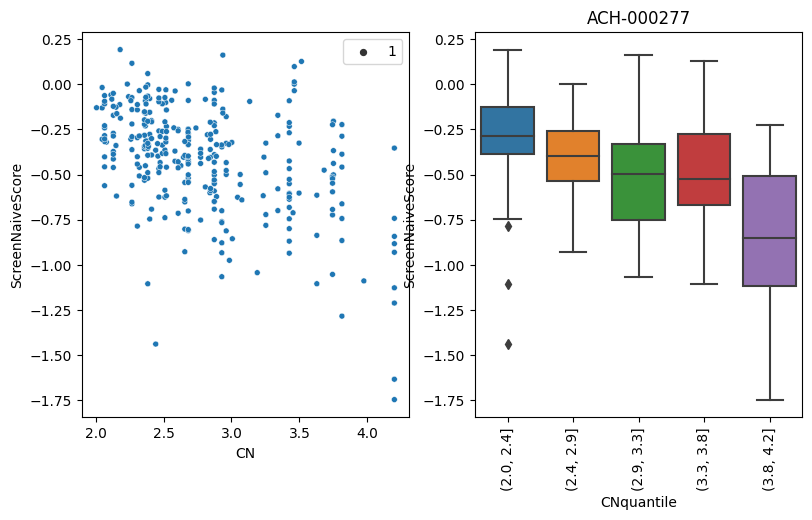

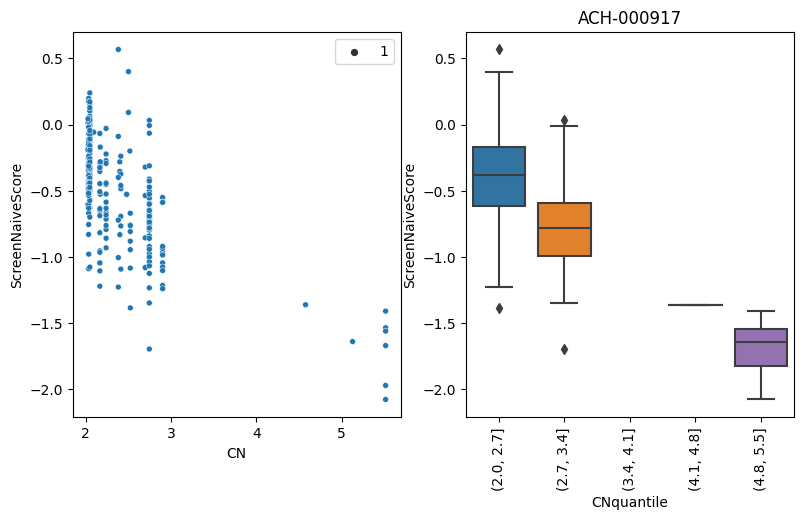

In [51]:
for sample in OmicsCNGene.var(axis=1).sort_values(ascending=False).index[:5]:
    try:
        pl_scatterplot_boxplot(sample, cnv_cutoff=2)
        plt.title(sample)
    except:
        print(sample)
    

(array([211., 254., 497., 515., 323., 166.,  81.,  26.,   9.,   2.]),
 array([0.00023193, 0.01356297, 0.02689401, 0.04022505, 0.05355609,
        0.06688713, 0.08021817, 0.09354921, 0.10688025, 0.12021129,
        0.13354233]),
 <BarContainer object of 10 artists>)

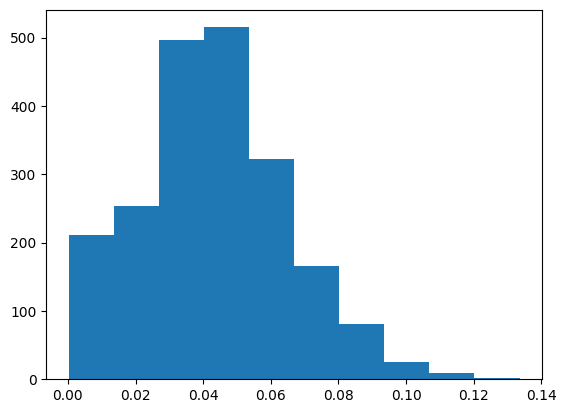

In [52]:
plt.hist(OmicsCNGene.var(axis=1))

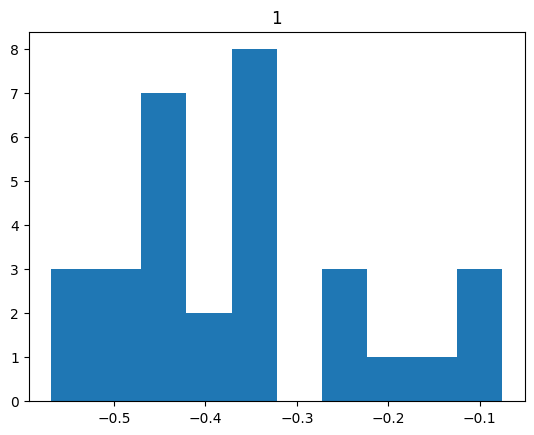

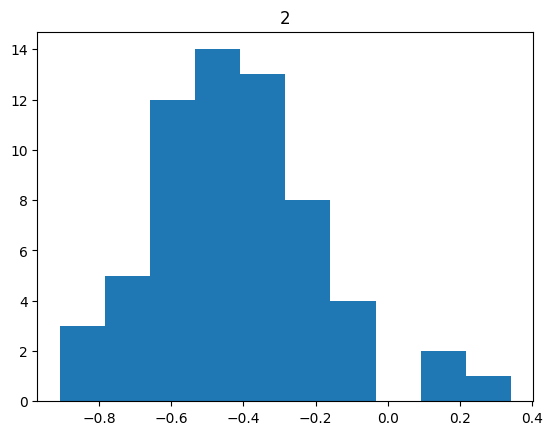

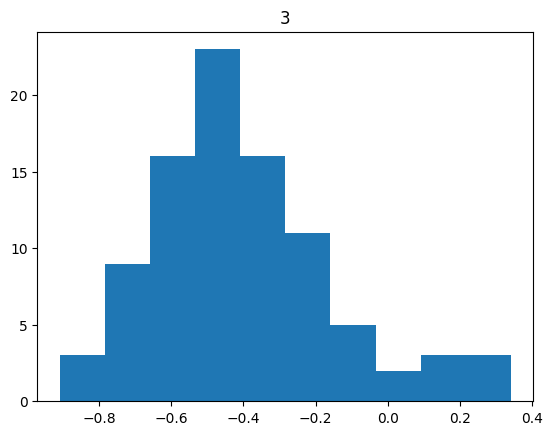

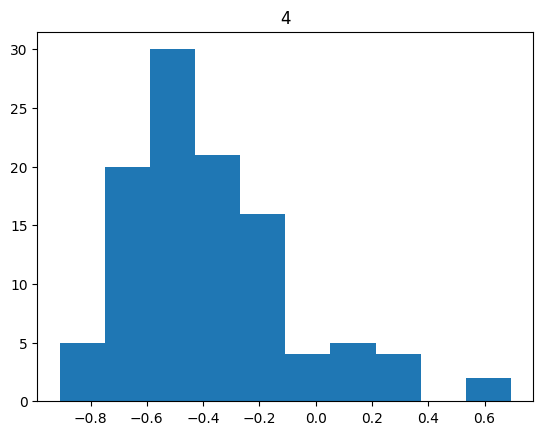

In [53]:
crispr_cnv = []
cutoffs = [1, 2, 3, 4]
for cutoff in cutoffs:
    for sample in OmicsCNGene.var(axis=1).sort_values(ascending=False).index[:50]:
        crispr_cnv.append(eval_cnv_expr_cor(sample, cnv_cutoff=cutoff))
    plt.figure()
    plt.hist(crispr_cnv)    
    plt.title(cutoff)

In [54]:
OmicsProfiles = tc.get(name='internal-23q2-1e49', version=59, file='OmicsProfiles')

In [55]:
OmicsProfiles.head()

,ProfileID,ModelConditionID,ModelID,Datatype,WESKit
0,PR-00UtU3,MC-001131-kkJv,ACH-001131,wgs,None
1,PR-01r7OM,MC-000957-Yckn,ACH-000957,rna,None
2,PR-02XmLG,MC-002785-qo9e,ACH-002785,rna,None
3,PR-04VvBz,MC-001289-BpdI,ACH-001289,wes,ICE
4,PR-09gmEI,MC-000520-YIm7,ACH-000520,rna,None


In [57]:
merged_gene_cn_profile = tc.get(name='cn-latest-d8d4', version=40, file='merged_gene_cn_profile')

[##################]100% |   2.0 MiB/s |  12.3 MiB /  12.3 MiB | Time:  0:00:06


In [58]:
merged_gene_cn_profile.head()

,DDX11L1 (84771),WASH7P (653635),MIR6859-1 (102466751),MIR1302-2 (100302278),FAM138A (645520),OR4F5 (79501),WASH9P (102723897),MIR6859-2 (102465909),OR4F29 (729759),AL669831.3 (101928626),...,BPY2C (442868),TTTY4C (474150),CSPG4P1Y (114758),CDY1 (9085),TTTY3 (114760),SNORD38B (94163),SCARNA4 (677771),SNORA50A (677830),SNORD3D (780854),POLR2J3 (548644)
PR-3cEXAx,2.114107,2.114107,2.114107,2.114107,2.114107,3.880916e-08,1.417715,1.417715,1.417715,1.417715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PR-E4gauh,1.019314,1.019314,1.019314,1.019314,1.019314,1.019314e+00,1.019314,1.019314,1.019314,1.019314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PR-wXb2sj,0.977269,0.977269,0.977269,0.977269,0.977269,9.772694e-01,0.977269,0.977269,0.977269,0.977269,...,0.729053,0.729053,0.729053,0.729053,0.729053,NaN,NaN,NaN,NaN,NaN
PR-yQKg9I,0.816312,0.816312,0.816312,0.816312,0.816312,8.163122e-01,0.816312,0.816312,0.816312,0.816312,...,0.479822,0.479822,0.479822,0.479822,0.479822,NaN,NaN,NaN,NaN,NaN
PR-7CTAVs,1.358684,1.358684,1.358684,1.358684,1.358684,1.358684e+00,1.358684,1.358684,0.000006,0.840994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [63]:
OmicsProfiles.ProfileID.isin(merged_gene_cn_profile.index).sum()

2727

In [67]:
OmicsProfiles.ProfileID.unique().shape

(4484,)

In [66]:
merged_gene_cn_profile.index.unique().shape

(2955,)

In [77]:
OmicsProfiles.loc[~OmicsProfiles.ProfileID.isin(merged_gene_cn_profile.index)].Datatype.unique()

array(['rna'], dtype=object)

In [86]:
OmicsDefaultModelProfiles.head()

,ModelID,ProfileID,ProfileType
0,ACH-000447,PR-Vd2mq2,rna
1,ACH-000447,PR-P7ivEQ,dna
2,ACH-000844,PR-edUTwR,rna
3,ACH-000844,PR-QzzYAo,dna
4,ACH-002438,PR-Jt5ZBG,dna


In [88]:
(~merged_gene_cn_profile.index.isin(OmicsProfiles.ProfileID)).sum()

561

In [89]:
(~merged_gene_cn_profile.index.isin(OmicsDefaultModelProfiles.ProfileID)).sum() 

873

In [90]:
protocol_map_dict = dict(zip(OmicsProfiles.ProfileID, OmicsProfiles.Datatype))
new_cnv_index = [protocol_map_dict.get(key, 'NA') for key in merged_gene_cn_profile.index]

In [95]:
model_map_dict = dict(zip(OmicsProfiles.ProfileID, OmicsProfiles.ModelID))
new_model = [model_map_dict.get(key, 'NA') for key in merged_gene_cn_profile.index]

In [91]:
merged_gene_cn_profile.loc[:, 'platform'] = new_cnv_index

In [97]:
merged_gene_cn_profile.loc[:, 'ModelID'] = new_model

In [98]:
merged_gene_cn_profile.head()

,DDX11L1 (84771),WASH7P (653635),MIR6859-1 (102466751),MIR1302-2 (100302278),FAM138A (645520),OR4F5 (79501),WASH9P (102723897),MIR6859-2 (102465909),OR4F29 (729759),AL669831.3 (101928626),...,CSPG4P1Y (114758),CDY1 (9085),TTTY3 (114760),SNORD38B (94163),SCARNA4 (677771),SNORA50A (677830),SNORD3D (780854),POLR2J3 (548644),platform,ModelID
PR-3cEXAx,2.114107,2.114107,2.114107,2.114107,2.114107,3.880916e-08,1.417715,1.417715,1.417715,1.417715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wgs,ACH-000667
PR-E4gauh,1.019314,1.019314,1.019314,1.019314,1.019314,1.019314e+00,1.019314,1.019314,1.019314,1.019314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wgs,ACH-001148
PR-wXb2sj,0.977269,0.977269,0.977269,0.977269,0.977269,9.772694e-01,0.977269,0.977269,0.977269,0.977269,...,0.729053,0.729053,0.729053,NaN,NaN,NaN,NaN,NaN,wgs,ACH-000159
PR-yQKg9I,0.816312,0.816312,0.816312,0.816312,0.816312,8.163122e-01,0.816312,0.816312,0.816312,0.816312,...,0.479822,0.479822,0.479822,NaN,NaN,NaN,NaN,NaN,NA,NA
PR-7CTAVs,1.358684,1.358684,1.358684,1.358684,1.358684,1.358684e+00,1.358684,1.358684,0.000006,0.840994,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NA,NA


In [107]:
# from depmap_omics_upload import tracker
# mytracker = tracker.SampleTracker(gumbo_env='production')
# pr_with_oncotree = mytracker.add_model_cols_to_prtable(cols=["ModelID", "depmap_model_type"])
# pr_with_oncotree.to_csv("all_meta_oncotree.tsv", sep='\t')

Starting cloud_sql_proxy for depmap-gumbo:us-central1:gumbo-cloudsql listening on port 5432


Exception: Failed to execute {command}. Have you run 'sh install_prereqs.sh' which should install cloud_sql_proxy in your path?

In [102]:
assert (merged_gene_cn_profile.platform=='NA').sum() == (merged_gene_cn_profile.ModelID == 'NA').sum()

In [103]:
merged_gene_cn_profile_nonull = merged_gene_cn_profile.loc[merged_gene_cn_profile.platform!='NA', :]

In [104]:
merged_gene_cn_profile_nonull.head()

,DDX11L1 (84771),WASH7P (653635),MIR6859-1 (102466751),MIR1302-2 (100302278),FAM138A (645520),OR4F5 (79501),WASH9P (102723897),MIR6859-2 (102465909),OR4F29 (729759),AL669831.3 (101928626),...,CSPG4P1Y (114758),CDY1 (9085),TTTY3 (114760),SNORD38B (94163),SCARNA4 (677771),SNORA50A (677830),SNORD3D (780854),POLR2J3 (548644),platform,ModelID
PR-3cEXAx,2.114107,2.114107,2.114107,2.114107,2.114107,3.880916e-08,1.417715,1.417715,1.417715,1.417715,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wgs,ACH-000667
PR-E4gauh,1.019314,1.019314,1.019314,1.019314,1.019314,1.019314e+00,1.019314,1.019314,1.019314,1.019314,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wgs,ACH-001148
PR-wXb2sj,0.977269,0.977269,0.977269,0.977269,0.977269,9.772694e-01,0.977269,0.977269,0.977269,0.977269,...,0.729053,0.729053,0.729053,NaN,NaN,NaN,NaN,NaN,wgs,ACH-000159
PR-P9a7Du,2.476574,2.476574,2.476574,2.476574,2.476574,2.476574e+00,0.796649,0.702516,0.702516,0.702516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wgs,ACH-001675
PR-egJh3A,1.241205,1.241205,1.241205,1.241205,1.241205,1.241205e+00,1.241205,1.241205,0.064566,0.842838,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,wgs,ACH-000947


In [105]:
merged_gene_cn_profile_nonull.platform.value_counts()

wes         1855
wgs          470
SNParray      69
Name: platform, dtype: int64

In [106]:
(merged_gene_cn_profile_nonull.ModelID.value_counts()>1).sum()

536

In [93]:
merged_segments_profile = tc.get(name='cn-latest-d8d4', version=40, file='merged_segments_profile')

In [94]:
merged_segments_profile.head()

,DepMap_ID,Chromosome,Start,End,SegmentMean,NumProbes,Status
0,PR-00UtU3,1,10001,7514727,0.848801,6365,0
1,PR-00UtU3,1,7514728,28452744,0.814937,19189,0
2,PR-00UtU3,1,28452745,41756578,0.827998,12815,0
3,PR-00UtU3,1,41756579,42098578,0.884138,342,0
4,PR-00UtU3,1,42098579,45896082,0.832715,3742,0
